# How to use fuvpy

fuvpy is a collection of functions to analyse and visualize auroral images.
The images are stored as xarray.Datasets and fuvpy includes a function to read .idl/.sav file generated with fuview3 or xvis (IMAGE and Polar softwave) into this format.

Images are loaded as follows:

In [1]:
import fuvpy as fuv
import pandas as pd
import numpy as np
import glob
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore",category =RuntimeWarning) # Turn of all the warnings when np.where contains NaNs. 

path = '../sample_wicfiles/'
wicfiles = glob.glob(path + '*.idl')
wic = fuv.readImg(wicfiles,dzalim=75)
wic

<xarray.Dataset>
Dimensions:     (date: 15, row: 256, col: 256)
Coordinates:
  * date        (date) datetime64[ns] 2000-08-28T09:28:42 ... 2000-08-28T09:5...
Dimensions without coordinates: row, col
Data variables:
    img         (date, row, col) float32 684.7 723.2 689.4 ... -485.1 -485.1
    mlat        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    mlon        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    mlt         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    glat        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    glon        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    dza         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    sza         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    hemisphere  (date) <U5 'north' 'north' 'north' ... 'north' 'north' 'north'
    id          <U3 'WIC'
    bad         (row, col) bool False False False False ... False False False

There are two ways to select images, by label or by index:

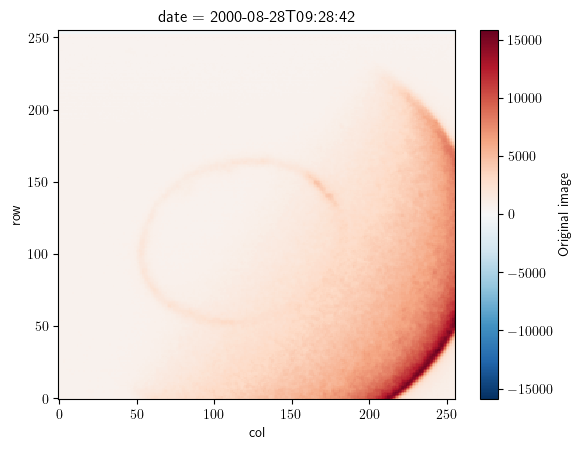

In [2]:
wic.sel(date='2000-08-28 09:28:42')['img'].plot()

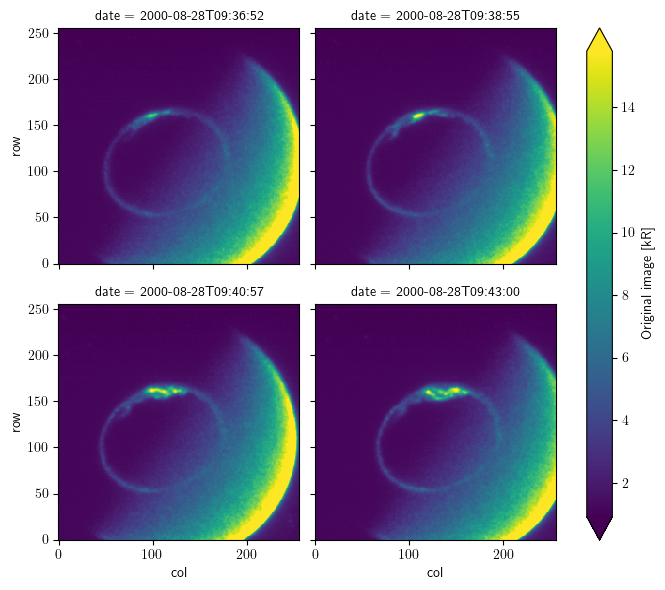

In [3]:
wic = fuv.getRayleigh(wic,'img')
wic.isel(date=slice(4,8))['imgR'].plot(x='col', y='row', col='date', col_wrap=2,robust=True)

In the same way we can visualize for instance the viewing anlge for these images:

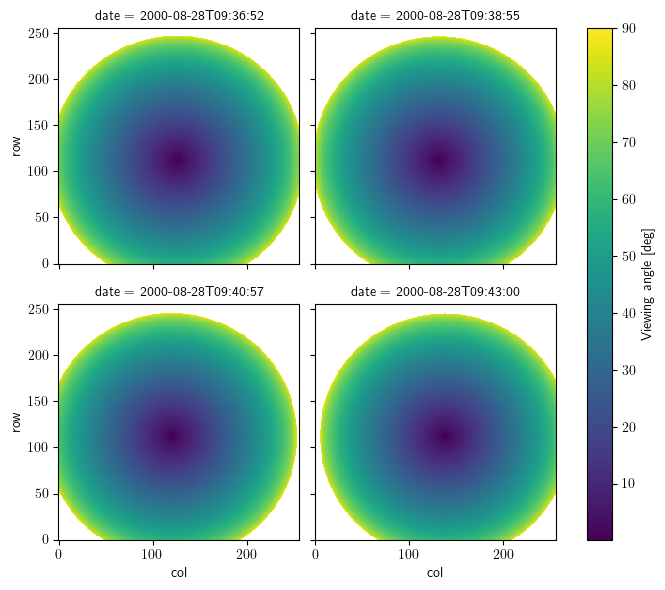

In [4]:
wic.isel(date=slice(4,8))['dza'].plot(x='col', y='row', col='date', col_wrap=2)

Note how the name and units of the variables appear automatically in the figures. They are added to each variable, and can be accessed (and assigned) using wic['nameofvariable'].attrs.

The images can be projected into polar coordinates by using polplot. fuv.plotimg is a wrapper to polplot's plotimg, and can be used as follows:

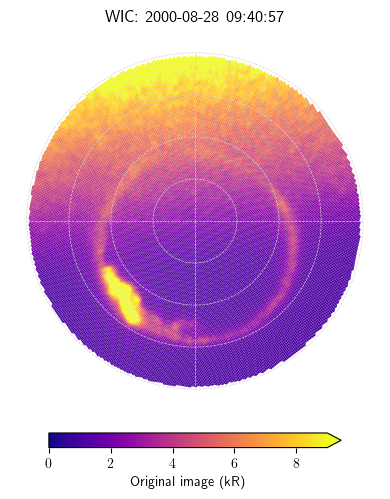

In [5]:
fig = plt.figure(figsize=(4,5))
ax = plt.subplot2grid((10, 1), (0, 0),rowspan=9)
pax = fuv.pp(ax)
fuv.plotimg(wic.isel(date=6),'imgR',pax=pax,crange=(0,9),cmap='plasma')

cax = plt.subplot2grid((10, 10), (9, 1),rowspan=1,colspan=8)
cax.axis('off')
cbar = plt.colorbar(pax.ax.collections[0],orientation='horizontal',ax=cax,fraction=1,extend='max')
cbar.set_label('{} ({})'.format(wic['imgR'].attrs['long_name'],wic['imgR'].attrs['units']))

ax.set_title(wic['id'].values.tolist() + ': ' + 
             wic.isel(date=6)['date'].dt.strftime('%Y-%m-%d %H:%M:%S').values.tolist())
# It should really be possible to simplify this line
plt.tight_layout()

In the above example, plotimg only does the polar projection and all other aspects of the plot must be done manually (like colorbar, title etc.). This is handy in subplots or when fine-tuning is needed. However, we sometimes just want a quick look at the images. This can be done using fuvpy.pplot, which resembles some of the functionality of xarrays 2D plot. 

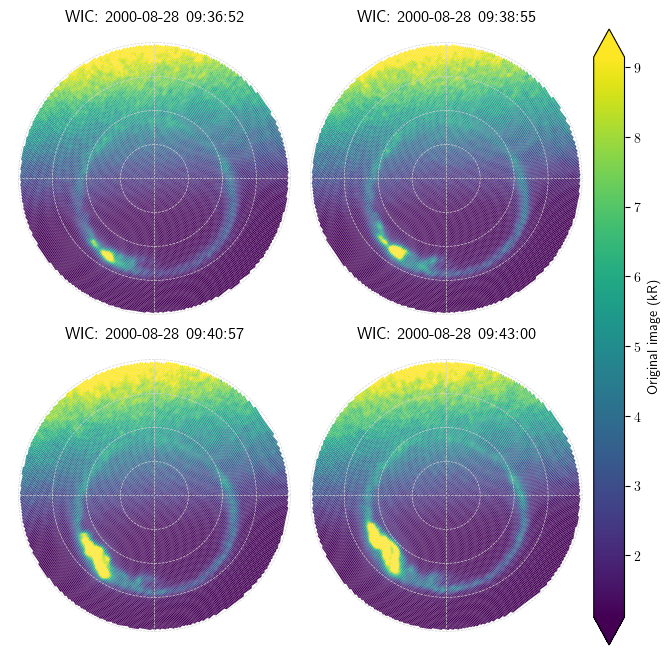

In [6]:
fuv.pplot(wic.isel(date=slice(4,8)),'imgR', col_wrap=2,robust=True,cbar_kwargs={'extend':'both'})

The images can also be plotted in an mlt-mlat projection. 

/Users/aohma/BCSS-DAG Dropbox/Anders Ohma/python/git/fuvpy/fuvpy/src/plotting.py:398: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabel.astype(int))


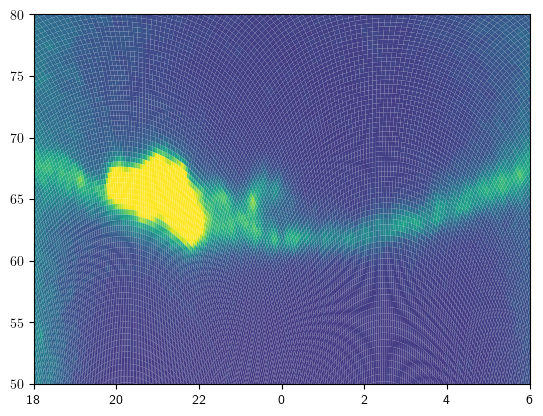

In [7]:
fuv.plotimgProj(wic.isel(date=6),inImg='img',crange=(0,4000))

Time to remove the dayglow. A simple version of the method is described in the appendix of *Ohma et al.* (2018), but the present version is more advanced and inludes a temporal fit using B-slines. Going retro, we use the colormap from the IMAGE mission. 

Building design matrix
Iteration: 0
Iteration: 1
Relative change model norm 0.011514098592871532
Iteration: 2
Relative change model norm 0.0033710318865929397
Iteration: 3
Relative change model norm 0.00047348597109731107


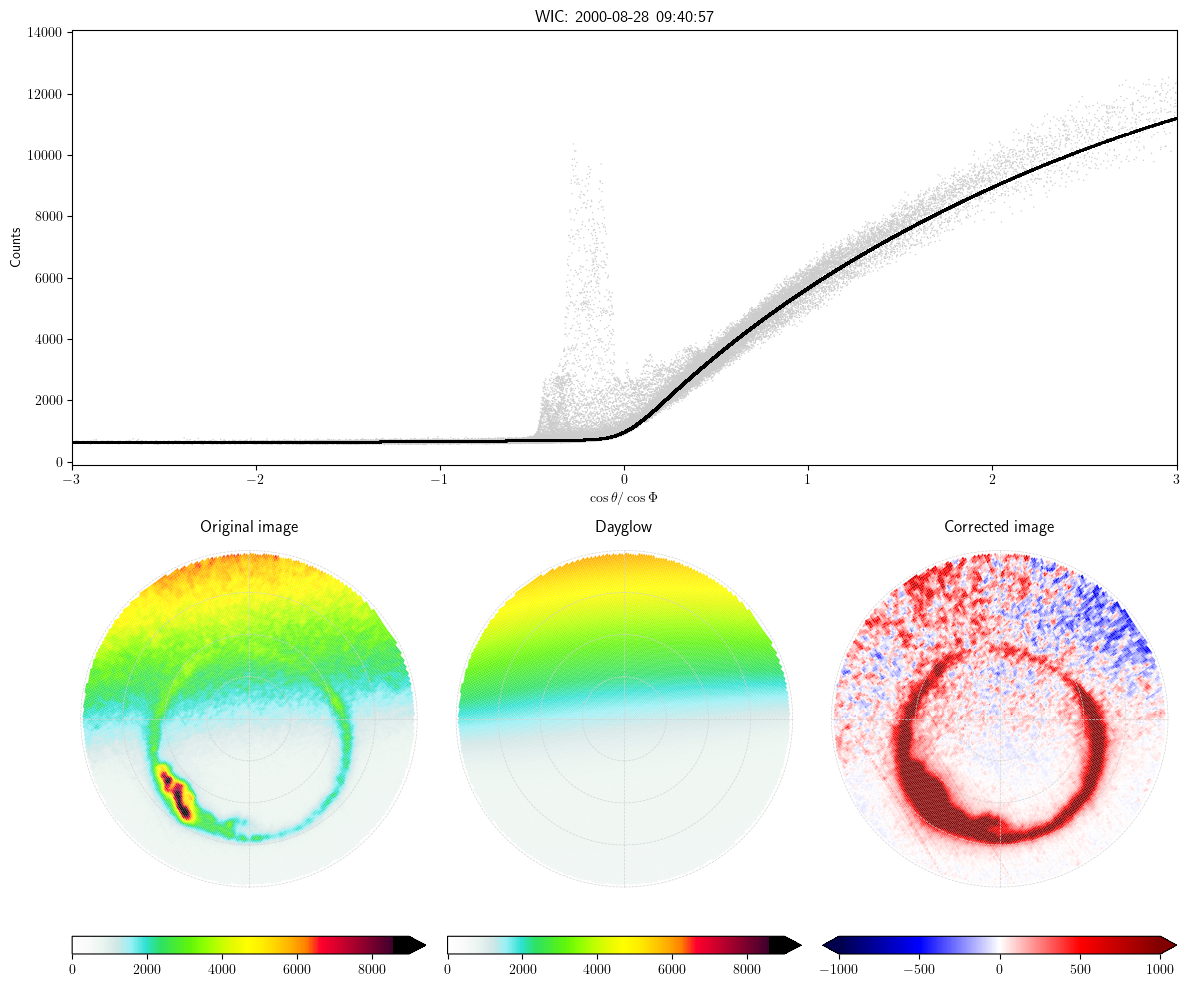

In [8]:
wic = fuv.makeBSmodel(wic,tukeyVal=5,tOrder=0)
fuv.showDGmodel(wic.isel(date=6),cmap=fuv.getIMAGEcmap())

Dayglow is subtracted, but the image is not perfect (note the asymmetry at the dayside). We model the residual background using a spherical harmonics model. Note the use of Dataset.pipe, which is handy for chained function calls.

Building sh G matrix
Iteration: 0
Iteration: 1
Relative change model norm: 0.16347604109491534
Iteration: 2
Relative change model norm: 0.03700662749906742
Iteration: 3
Relative change model norm: 0.009809191903622366
Iteration: 4
Relative change model norm: 0.002837702700035857
Iteration: 5
Relative change model norm: 0.0008555600832636954


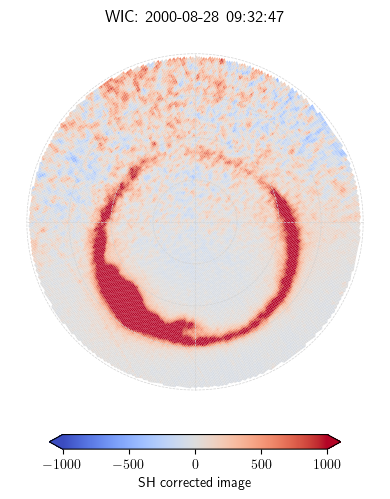

In [9]:
wic = wic.pipe(fuv.makeSHmodel,4,4,dampingVal=1e-4)

# Figure
fig = plt.figure(figsize=(4,5))
ax = plt.subplot2grid((10, 1), (0, 0),rowspan=9)
pax = fuv.pp(ax)
fuv.plotimg(wic.isel(date=6),'shimg',pax=pax,crange=(-1000,1000),cmap='coolwarm')

cax = plt.subplot2grid((10, 10), (9, 1),rowspan=1,colspan=8)
cax.axis('off')
cbar = plt.colorbar(pax.ax.collections[0],orientation='horizontal',ax=cax,fraction=1,extend='both')
cbar.set_label('{}'.format(wic['shimg'].attrs['long_name']))

ax.set_title(wic['id'].values.tolist() + ': ' + 
             wic.isel(date=2)['date'].dt.strftime('%Y-%m-%d %H:%M:%S').values.tolist())
# It should really be possible to simplify this line
plt.tight_layout()

This is staring to look great! To further examine the performance of the background subtraction, we plot the background corrected counts (residual counts) vs solar zenith angle and and the original vs modelled counts:

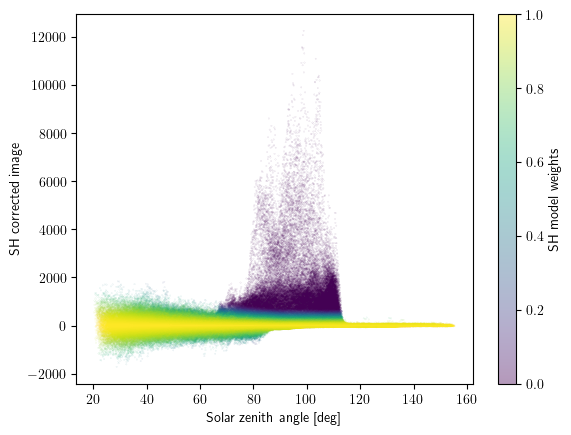

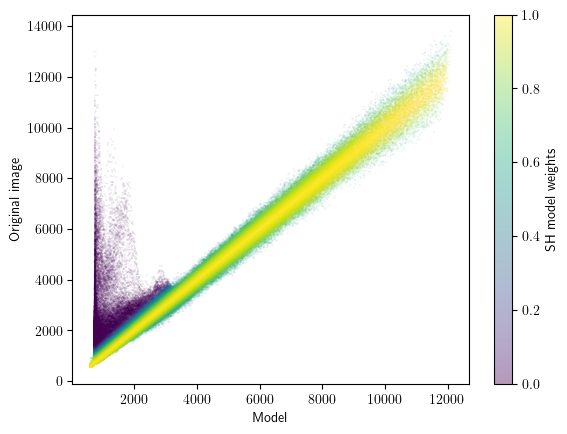

In [10]:
plt.figure()
wic.plot.scatter(x='sza',y='shimg',hue='shweight',s=0.01,alpha=0.4)
wic['Model'] = wic['dgmodel'] + wic['shmodel']
plt.figure()
wic.plot.scatter(x='Model',y='img',hue='shweight',s=0.01,alpha=0.4)